<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/comment/ch04_06_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.06 AutoEncoder

* 날짜:
* 이름:

## 학습내용
    - AutoEncoder를 이해하고 구현한다.
    - Denoising 을 적용해 본다. 
    - 이상치 탐지를 적용해 본다. 

In [1]:
import sys, os
sys.path.append('/content/drive/MyDrive/scripts/')
from lib import *

## AutoEncoder 기본 구현
---

![](https://gaussian37.github.io/assets/img/dl/concept/autoencoder2/autoencoder.png)

### **| 모델 구성**

In [ ]:
# 이미지 -> 이미지 norm : x/255 x 값이 0~1 사이 (0 또는 1이 아님!)

# mnist : 28 x 28 = 784
def create_model(input_dims=784):
  # encoder
  x = layers.Input(shape=input_dims, name='x')
  z = layers.Dense(128, activation='relu')(x)
  z = layers.Dense(64, activation='relu')(z)
  z = layers.Dense(16, activation='relu')(z)
  encoder = models.Model(x, z, name='Encoder')

  # decoder
  y = layers.Dense(64, activation='relu')(z)
  y = layers.Dense(128, activation='relu')(y)
  y = layers.Dense(input_dims, activation='sigmoid')(y)
  decoder = models.Model(z, y, name='Decoder')

  # AutoEncoder
  z = encoder(x)
  y = decoder(z)
  model = models.Model(x, y, name='AutoEncoder')
  model.compile(loss= 'mse', 
                optimizer='adam')

  model.summary()

  return encoder, decoder, model

# def create_cnnbase(input_dims):

# 다른 데이터

In [ ]:
encoder, decoder, model = create_model()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 784)]             0         
                                                                 
 Encoder (Functional)        (None, 16)                109776    
                                                                 
 Decoder (Functional)        (None, 784)               110544    
                                                                 
Total params: 220,320
Trainable params: 220,320
Non-trainable params: 0
_________________________________________________________________


### **| 학습**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# norm
x_train = x_train / 255.0
x_test = x_test / 255.

# flatten
x_train = x_train.reshape( (60000, -1) )
x_test = x_test.reshape( (10000, -1) )

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [ ]:
history = model.fit(x_train, x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 5s 9ms/step - loss: 0.0508
Epoch 2/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0266
Epoch 3/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0232
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0216
Epoch 5/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0205
Epoch 6/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0196
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0186
Epoch 8/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0176
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0169
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0163
Epoch 11/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0159
Epoch 12/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0156
Epoch 13/50
469/469 [====

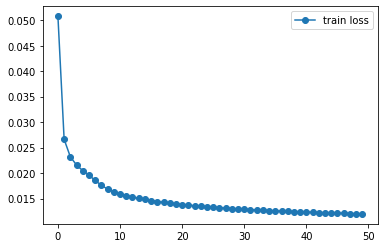

In [ ]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [ ]:
x_recon = model.predict(x_test)
x_test.shape, x_recon.shape

((10000, 784), (10000, 784))

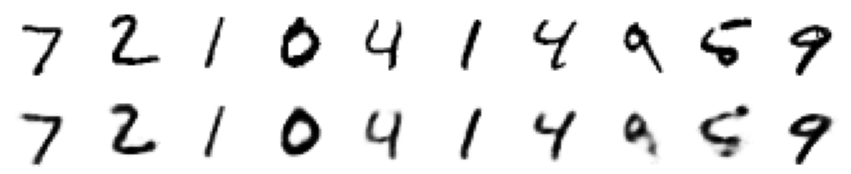

In [ ]:
def display_res(org, rec):
  plt.figure(figsize=(15,3))
  for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(org[i].reshape(28,28), cmap='gray_r')
    plt.axis('off')
    plt.subplot(2,10,i+11)
    plt.imshow(rec[i].reshape(28,28), cmap='gray_r')
    plt.axis('off')
  plt.show()

display_res(x_test, x_recon)

In [ ]:
z =encoder(x_test[:1000])
z.shape

TensorShape([1000, 16])

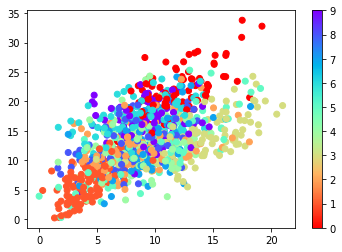

In [ ]:
plt.scatter(z[:,1], z[:,2], c=y_test[:1000], cmap='rainbow_r')
plt.colorbar()

## AutoEncoder 활용 - Denoising
---

### **| 데이터 준비**

(60000, 784) (10000, 784)


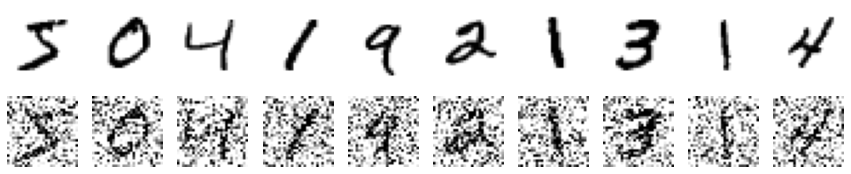

In [ ]:
train_noise = np.random.normal(size=x_train.shape)
test_noise = np.random.normal(size=x_test.shape)

factor = 0.6
x_train_noisy = x_train + train_noise * factor
x_test_noisy = x_test + test_noise * factor

# 0~1 범위를 벗어나지 않도록
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(train_noise.shape, test_noise.shape)
display_res(x_train, x_train_noisy)

### **| 훈련**

In [ ]:
history = model.fit(x_train_noisy, x_train , epochs=50, batch_size=128)

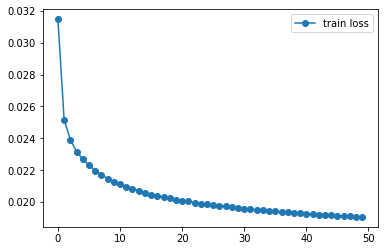

In [ ]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [ ]:
x_recon = model.predict(x_test_noisy)
x_recon.shape, x_test_noisy.shape

((10000, 784), (10000, 784))

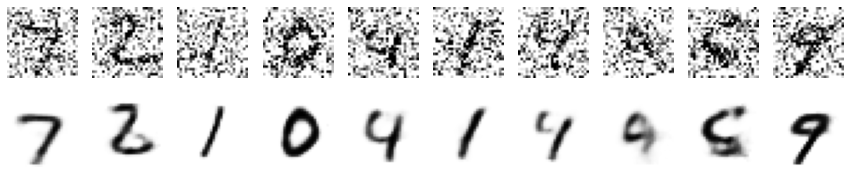

In [ ]:
display_res(x_test_noisy, x_recon)

## AutoEncoder 활용 - 이상치 탐지
---

### **| 모델 구성**

In [126]:
# conv1d 레이어 사용해서 모델 구성

def create_model(input_shape=(288,1)):

  def conv(x, filters, strides=2, activation='relu'):
    y = layers.Conv1D(filters=filters, 
                      kernel_size = 7,
                      padding = 'same', 
                      strides = strides, 
                      activation = activation)(x)
    return y

  def convT(x, filters, strides=2, activation='relu'):
    y = layers.Conv1DTranspose(filters=filters, 
                                kernel_size = 7,
                                padding = 'same', 
                                strides = strides, 
                                activation = activation)(x)
    return y

  # Encoder
  x = layers.Input(shape=input_shape)
  y = conv(x, 32)
  y = layers.Dropout(.2)(y)
  y = conv(y, 8)

  # Decoder
  y = convT(y, 32)
  y = layers.Dropout(.2)(y)
  y = convT(y, 1, activation=None)

  model = models.Model(x, y)
  model.summary()

  model.compile(optimizer='adam', loss='mse')

  return model

create_model()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 288, 1)]          0         
                                                                 
 conv1d_25 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_26 (Conv1D)          (None, 72, 8)             1800      
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 144, 32)          1824      
 Transpose)                                                      
                                                                 
 dropout_1 (Dropout)         (None, 144, 32)           0         
                                                           

### **| 데이터 준비**


In [106]:
# 데이터 : 시계열 데이터
# 데이터 하나의 shape : (288, 1)

data_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
train_path ="artificialNoAnomaly/art_daily_small_noise.csv"
test_path =  "artificialWithAnomaly/art_daily_jumpsup.csv"

In [107]:
df_train = pd.read_csv(data_url+train_path, parse_dates=True, index_col="timestamp")
df_test = pd.read_csv(data_url+test_path, parse_dates=True, index_col="timestamp")
print(df_train.shape, df_test.shape)

(4032, 1) (4032, 1)


In [108]:
# 정규화 - 평균 0, 표준편차 1
mean = df_train.mean()
std = df_train.std()

df_train_norm = (df_train - mean) / std
df_test_norm = (df_test - mean) /std

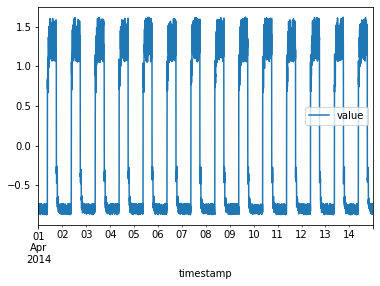

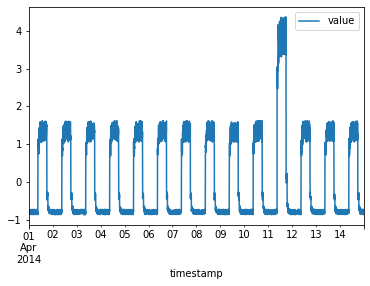

In [109]:
df_train_norm.plot()
df_test_norm.plot()

In [110]:
def create_seq(x,
               window_size=288,
               time_step=1 ):
  y = []
  for i in range(len(x) - window_size + 1):
    if i%time_step==0:
      seq = x[i : (i+window_size)]
      y.append(seq)
  return np.array(y)

train = create_seq(df_train_norm)   
print(f'Train: {train.shape}')

Train: (3745, 288, 1)


In [111]:
test = create_seq(df_test_norm, time_step=288)
print(f'Test: {test.shape}')

Test: (14, 288, 1)


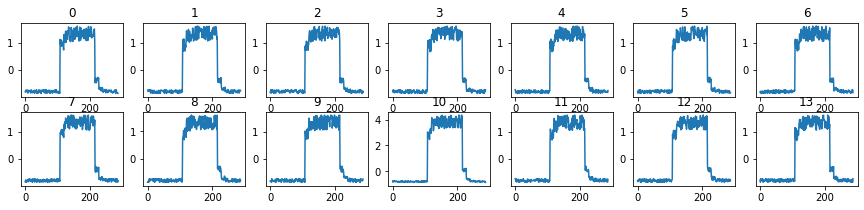

In [112]:
plt.figure(figsize=(15,3))
for i in range(14):
  plt.subplot(2,7,i+1)
  plt.title(i)
  plt.plot(test[i])

### **| 훈련**

In [127]:
model = create_model()
history = model.fit(train, train, epochs=30, batch_size=16)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 288, 1)]          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_28 (Conv1D)          (None, 72, 8)             1800      
                                                                 
 conv1d_transpose_20 (Conv1D  (None, 144, 32)          1824      
 Transpose)                                                      
                                                                 
 dropout_3 (Dropout)         (None, 144, 32)           0         
                                                          

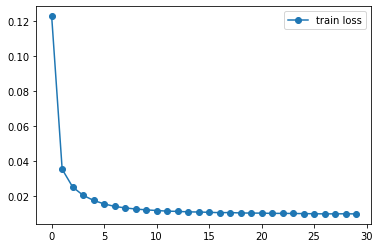

In [128]:
l = history.history['loss']
plt.plot(l, marker='o', label='train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [129]:
# 예측
train_pred = model.predict(train)
test_pred = model.predict(test)

train_pred.shape, train.shape, test.shape, test_pred.shape

((3745, 288, 1), (3745, 288, 1), (14, 288, 1), (14, 288, 1))

첫번째 테스트 샘플의 오차: [0.02660888]


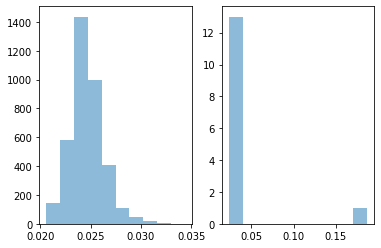

In [130]:
train_mae = np.mean( np.abs(train - train_pred) , axis=1)
test_mae = np.mean( np.abs(test - test_pred) , axis=1)
train_mae.shape, test_mae.shape
print(f'첫번째 테스트 샘플의 오차: {test_mae[0]}')
plt.subplot(121);plt.hist(train_mae, alpha=.5)
plt.subplot(122);plt.hist(test_mae, alpha=.5)
plt.show()

샘플 [10] 손실값: 0.19


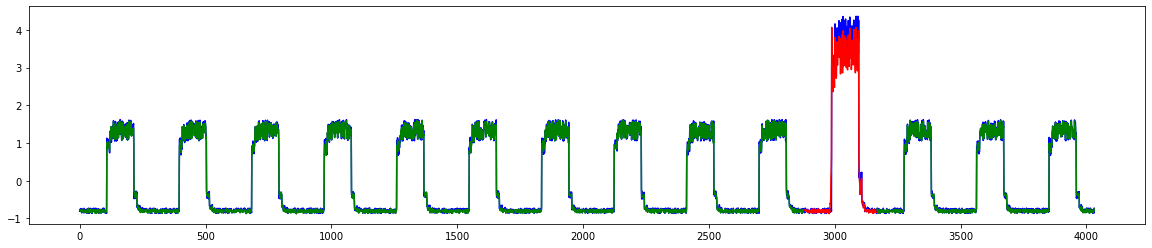

In [134]:
window_size = 288
plt.figure(figsize=(20,4))
for idx in range(len(test)):
  plt.plot(range(window_size*idx, window_size*(idx+1)),test[idx], c='b')
  l = test_mae[idx][0]
  if l>0.1:  
    print(f'샘플 [{idx}] 손실값: {test_mae[idx][0]:.2f}')
    plt.plot(range(window_size*idx, window_size*(idx+1)),test_pred[idx], c='r')
  else: 
    plt.plot(range(window_size*idx, window_size*(idx+1)),test_pred[idx], c='g')

plt.show()